In [ ]:
# !pip install faiss-gpu
# # !pip install faiss-cpu
# !pip install -U sentence-transformers


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pickle

In [2]:
# Mount into drive 
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [4]:
ls

 assignment4/
 BertSemanticSearchEngine.pickle
'Colab Notebooks'/
 count_based_plot_similarity.pickle
 generated_queries_all.tsv
 model_based_plot_similarity_keywords.pickle
 model_based_plot_similarity_paraphrased_plots.pickle
 model_based_plot_similarity.pickle
 movie_plot.index
 movie_titles
 paraphrased_beginning_plots.pickle
 paraphrased_plots.pickle
 search/
 TopologicalSearchEngine_2.pickle
 TopologicalSearchEngine.pickle
 TopologicalSemanticSearchEngine.pickle
 TopologicalSemanticSearchEngine_version_2.pickle
 TunedBertSemanticSearchEngine.pickle
 tuned_msmarco-distilbert-base-dot-prod-v3/
'Untitled document.gdoc'
 vecs.feather
 vocab.csv
 wiki_movie_plots_deduped.csv


In [10]:
import numpy as np
import torch
import os
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import faiss
from sentence_transformers import SentenceTransformer

In [6]:
df = pd.read_csv("wiki_movie_plots_deduped.csv")
df.head(1)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."


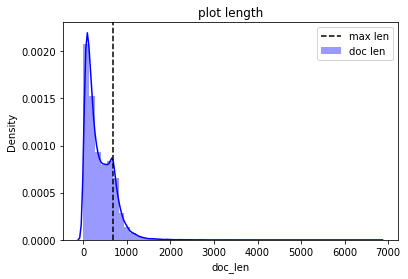

In [11]:
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [14]:
df['doc_len'].describe(), np.median(df['doc_len'])

(count    34886.000000
 mean       372.493206
 std        315.753223
 min          2.000000
 25%        122.000000
 50%        284.000000
 75%        581.000000
 max       6752.000000
 Name: doc_len, dtype: float64, 284.0)

In [ ]:
max_seq_len

688

And for this experiment, i am choosing “sentence-transformers/msmarco-distilbert-base-dot-prod-v3” model which performs great in Semantic Textual Similarity (Asymmetric ) tasks and it’s quite faster than BERT as it is considerably smaller. This model was optimized to be used with dot-product as a similarity function between queries and documents.
For short descriptions, “distilbert-base-nli-stsb-mean-tokens”, works a lot better and faster.


In [ ]:
class BertSemanticSearchEngine:
    def __init__(self, model_type, data, target_feature, fine_tune=False):
      self.model_type = model_type
      self.model = SentenceTransformer(self.model_type)
      self.data = data
      self.target_feature = target_feature
      self.target_data = self.data[target_feature]
      self.encoded_data = None
      self.faissIndex = None
      if fine_tune:
        from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
        self.synthetic_generator_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-nl")
        self.synthetic_generator_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-nl")
        self.synthetic_queries = []
        self.orig_texts = []
        self.training_data = []

    def construct_embeddings(self):
      self.encoded_data = np.asarray(self.model.encode(self.target_data).astype('float32'))
      self.faissIndex = faiss.IndexIDMap(faiss.IndexFlatIP(768))
      self.faissIndex.add_with_ids(self.encoded_data, np.array(range(0, len(self.target_data))))

    def get_synthetic_queries(self, batch_size=32, num_queries_for_each=3, max_length=None, query_max_len=20, 
                              doc_len=None, output_filename='synthetic_query.tsv'):
      import tqdm
      def filter_out_non_ascii(s): 
        return "".join(i for i in s if ord(i) < 128)
      if doc_len is None:
        doc_len = len(self.target_data)

      if max_length is None:
        doc_len = self.target_data.apply(lambda words: len(words.split()))
        max_length = np.round(doc_len.mean()+doc_len.std()).astype(int)
      for i in tqdm(range(0, doc_len, batch_size)):
        text = list(self.target_data[i : i + batch_size])
        tokens = self.synthetic_generator_tokenizer(text, max_length=max_length, truncation=True, padding=True, return_tensors='pt')
        generated_text = self.synthetic_generator_model.generate(tokens.input_ids, max_length=query_max_len, do_sample=True, 
                                                                 top_p=0.97, num_return_sequences=num_queries_for_each)
      for i, txt in enumerate(generated_text):
        synthetic_query = filter_out_non_ascii(self.synthetic_generator_tokenizer.decode(txt, skip_special_tokens=True))
        orig_text = filter_out_non_ascii(text[int(i/num_queries_for_each)])
        self.synthetic_queries.append(synthetic_query.replace("\t", " ").strip())
        self.orig_texts.append(orig_text.replace("\t", " ").strip())
      if output_filename is not None:
        with open(output_filename, 'w') as fOut:
          for q, t in zip(self.synthetic_queries, self.orig_texts):
           fOut.write("{}\t{}\n".format(q, t))

    def fine_tune(self, output_filename=None, batch_size=16, epochs=10, show_progress_bar=False, save=True):
      from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
      from torch import nn
      import os
      word_embedding_layer = models.Transformer('sentence-transformers/{}'.format(self.model_type))
      pooling_layer = models.Pooling(word_embedding_layer.get_word_embedding_dimension())
      dense_layer = models.Dense(in_features=768, out_features=768, bias=False)
      model_to_tune = SentenceTransformer(modules=[word_embedding_layer, pooling_layer, dense_layer])
      if output_filename is None:
        for q, t in zip(self.synthetic_queries, self.orig_texts):
          self.training_data.append(InputExample(texts=[q, t]))
      else:
        with open(output_filename) as fIn:
          for content in fIn:
            try:
              q, t = content.strip().split('\t', maxsplit=1)
              self.training_data.append(InputExample(texts=[q, t]))
            except:
              pass
      # no duplicates for MultipleNegativesRankingLoss
      dataloader = datasets.NoDuplicatesDataLoader(self.training_data, batch_size=batch_size)
      loss_func = losses.MultipleNegativesRankingLoss(model_to_tune)
      model_to_tune.fit(train_objectives=[(dataloader, loss_func)], epochs=epochs, show_progress_bar=show_progress_bar)
      self.model = model_to_tune
      if save:
        self.model.save('tuned_{}'.format(self.model_type))

    def retrieve_data(self, idx):
      return dict((feat, self.data.iloc[idx][feat]) for feat in self.data.iloc[idx].index)
    
    def search(self, query, show_n):
      encoded_query = self.model.encode([query])
      res = self.faissIndex.search(encoded_query, show_n)
      res_ids = list(np.unique(res[1].tolist()[0]))
      results = [self.retrieve_data(i) for i in res_ids]
      return results
    
    def display_results(self, query, show_n):
      res = self.search(query, show_n)
      print('Showing {} searched results based on your query!'.format(show_n))
      for idx, r in enumerate(res):
        print('Found result #{} - {}'.format(idx, r))

Since we are using FAISS, storing embeddings is easy, once we have settled with Index Factory and Mappings.

We have encoded our Movie Plot, where each plot has been encoded with a 768-dimensional vector and stored to disk with movie_plot.index name.
Note here we have used index.add_with_ids and this encodes data in the order of data-frame and stores their index ids too.

In [ ]:
untuned_bert_semantic_search = BertSemanticSearchEngine('msmarco-distilbert-base-dot-prod-v3', df, 'Plot')
untuned_bert_semantic_search.construct_embeddings()

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [ ]:
untuned_bert_semantic_search.search('Thriller', 1)

[{'Release Year': 2015,
  'Title': 'Eadweard',
  'Origin/Ethnicity': 'Canadian',
  'Director': 'Kyle Rideout',
  'Cast': 'Michael Eklund, Sara Canning, Christopher Heyerdahl, Torrance Coombs, Jodi Balfour',
  'Genre': 'biopic of pioneering american photographer eadweard muybridge',
  'Wiki Page': 'https://en.wikipedia.org/wiki/Eadweard_(film)',
  'Plot': "A psychological drama centred around world-famous turn-of-the-century photographer, Eadweard Muybridge who photographed nude and deformed subjects, became the godfather of cinema, murdered his wife's lover, and was the last American to receive the justifiable homicide verdict."}]

In [ ]:
untuned_bert_semantic_search.display_results('Thriller', 1)

Showing 1 searched results based on your query!
Found result #0 - {'Release Year': 2015, 'Title': 'Eadweard', 'Origin/Ethnicity': 'Canadian', 'Director': 'Kyle Rideout', 'Cast': 'Michael Eklund, Sara Canning, Christopher Heyerdahl, Torrance Coombs, Jodi Balfour', 'Genre': 'biopic of pioneering american photographer eadweard muybridge', 'Wiki Page': 'https://en.wikipedia.org/wiki/Eadweard_(film)', 'Plot': "A psychological drama centred around world-famous turn-of-the-century photographer, Eadweard Muybridge who photographed nude and deformed subjects, became the godfather of cinema, murdered his wife's lover, and was the last American to receive the justifiable homicide verdict."}


In [ ]:
# save
import pickle
pickle_out = open(f"BertSemanticSearchEngine.pickle", "wb")
pickle.dump(untuned_bert_semantic_search, pickle_out)
pickle_out.close()

In [ ]:
# # load
# import pickle
# pickle_in = open("BertSemanticSearchEngine.pickle", "rb")
# untuned_bert_semantic_search = pickle.load(pickle_in)
# pickle_in.close()

In [ ]:
# !pip install sacremoses

In [ ]:
tuned_bert_semantic_search = BertSemanticSearchEngine('msmarco-distilbert-base-dot-prod-v3', df, 'Plot', fine_tune=True)
tuned_bert_semantic_search.get_synthetic_queries()
tuned_bert_semantic_search.fine_tune(epochs=10, show_progress_bar=True)

In [ ]:
tuned_bert_semantic_search.construct_embeddings()

In [ ]:
pickle_out = open(f"TunedBertSemanticSearchEngine.pickle", "wb")
pickle.dump(tuned_bert_semantic_search, pickle_out)
pickle_out.close()

In [ ]:
# pickle_in = open("TunedBertSemanticSearchEngine.pickle", "rb")
# tuned_bert_semantic_search = pickle.load(pickle_in)
# pickle_in.close()

In [ ]:
untuned_bert_semantic_search.display_results('Thriller', 3)

Showing 3 searched results based on your query!
Found result #0 - {'Release Year': 1956, 'Title': 'Portrait of Alison', 'Origin/Ethnicity': 'British', 'Director': 'Guy Green', 'Cast': 'Robert Beatty, Terry Moore', 'Genre': 'crime', 'Wiki Page': 'https://en.wikipedia.org/wiki/Portrait_of_Alison', 'Plot': "The film opens with a car plunging over a cliff in Italy. The killed driver is newspaperman Lewis Forrester. The woman with him is supposedly Alison Ford, an actress. But she wasn’t actually in the car and turns up later in England to try and solve what was in truth a murder to shut the newspaper man up, not an accident. She solicits the help of Forrester's brother, Tim, an artist. Then, as the story unfolds, a number of mysterious, unsolved questions keep emerging, along with two more murders and a suicide. And before it's over it has been learned that an international ring of diamond thieves is at the bottom of everything, that no less than four of the major characters are part of it

In [ ]:
tuned_bert_semantic_search.display_results('Thriller', 3)

Showing 3 searched results based on your query!
Found result #0 - {'Release Year': 1939, 'Title': 'The Nursemaid Who Disappeared', 'Origin/Ethnicity': 'British', 'Director': 'Arthur B. Woods', 'Cast': 'Arthur Margetson, Peter Coke', 'Genre': 'crime', 'Wiki Page': 'https://en.wikipedia.org/wiki/The_Nursemaid_Who_Disappeared', 'Plot': 'In this thriller, a playwright overhears a gang of men plotting a kidnapping and enlists the assistance of a detective to investigate them. They soon find the ring is fronted by a bogus employment agency that sends "clients" to check out potential victims. Action ensues as they endeavor to stop them.[4]'}
Found result #1 - {'Release Year': 2003, 'Title': 'Jodi Kya Banayi Wah Wah Ramji', 'Origin/Ethnicity': 'Bollywood', 'Director': 'Unknown', 'Cast': nan, 'Genre': ' ', 'Wiki Page': 'https://en.wikipedia.org/wiki/Jodi_Kya_Banayi_Wah_Wah_Ramji', 'Plot': "The story is a riotous comedy about a suspense thriller writer's search for a love affair.[1]"}
Found resu

In [ ]:
# import sys
# !{sys.executable} -m pip install gensim nltk scikit-learn rank_bm25

In [ ]:
# !python -m pip install -U giotto-tda

In [ ]:
# !pip install rake-nltk

In [ ]:
from sklearn.cluster import DBSCAN
from gtda.mapper import CubicalCover, make_mapper_pipeline
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import chain
import pandas as pd
import nltk
from nltk.corpus import reuters
from nltk.corpus import stopwords
import re
import random
import gensim.downloader as api
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import reuters
import numpy as np
from gtda.mapper import plot_static_mapper_graph

nltk.download('stopwords', quiet=True)

True

In [ ]:
import nltk
nltk.download('wordnet', quiet=True)

True

In [ ]:
class TopologicalSemanticSearchEngine:

    def __init__(self, data, data_dict, model, pca_n_components=100, tsne_n_components=2, metric="cosine", n_intervals=10, overlap_frac=0.3, n_jobs=2):
        self.data = data # df['Plot']
        self.data_dict = data_dict # {row['Plot']: {'Title': row['Title'], 'Release Year': row['Release Year'], 'Origin/Ethnicity': row['Origin/Ethnicity'], 'Genre': row['Genre'] } for i, row in df.iterrows()}
        self.get_vector_vocab(self.data, model)
        self.train_data = self.vocabulary.iloc[:, 2:].values
        self.tsne_dim_reduc = self.apply_tsne_dim_reduc(pca_n_components=pca_n_components, tsne_n_components=tsne_n_components, metric=metric)
        self.clusterer = DBSCAN(metric="cosine")
        self.cover = CubicalCover(n_intervals=n_intervals, overlap_frac=overlap_frac)
        self.pipeline = make_mapper_pipeline(filter_func=self.tsne_dim_reduc, cover=self.cover, clusterer=self.clusterer, verbose=False, n_jobs=n_jobs)
        self.graph = self.pipeline.fit_transform(self.train_data) 
        self.get_word_node_map()

    def apply_tsne_dim_reduc(self, pca_n_components, tsne_n_components, metric):
        self.pca_model = PCA(n_components=pca_n_components)
        self.train_data = self.pca_model.fit_transform(self.train_data)
        self.tsne = TSNE(n_components=tsne_n_components, metric=metric, random_state=1)
        self.train_data_transformed = self.tsne.fit_transform(self.train_data)

    def remove_stopwords_symbols(self, string_list):
      nltk.download("stopwords", quiet=True)
      def remove_stop_words(text, stopWords):
        text = text.split(" ")
        return " ".join([y for y in text if y not in stopWords])
      # get stop words
      en_stopWords = set(stopwords.words("english"))
      string_series = pd.Series(string_list).str.lower()
      if any('http' in i for i in string_series):
        string_series = string_series.apply(lambda x: re.sub(r"http\S+", " ", str(x)))
      # remove all that is not en. characters or numbers
      string_series = string_series.str.replace("[^a-zA-Z0-9]", " ", regex=True)
      # remove symbols
      string_series = string_series.str.replace(" +", " ", regex=True)
      # remove stop words
      string_series = string_series.apply(lambda i: remove_stop_words(i, en_stopWords))
      return string_series

    def get_data_vector(self, data, model):
      def make_vec(text, index, vocabulary, model):
        vectors = []
        for word in set(text.split(" ")):
          #try except
          vectors.append((index, word))
          if word not in vocabulary:
            vocabulary[word] = model.encode(word)
        return vectors

      vocabulary = {}
      vectors = []
      for idx, text in enumerate(data):
        vectors += make_vec(text, idx, vocabulary, model)
      return vectors, vocabulary

    def get_vector_vocab(self, text, model): 
      vectors, vocabulary = self.get_data_vector(self.remove_stopwords_symbols(text), model)
      vectors = pd.concat([pd.Series([i[0] for i in vectors]), pd.DataFrame(np.array([i[1] for i in vectors]))], axis=1)
      vectors.columns = [x if i > 0 else 'index' for i, x in enumerate(vectors.columns)]
      vectors.columns = [x if i != 1 else 'word' for i, x in enumerate(vectors.columns)]

      vocabulary = [(i, vocabulary[i]) for i in vocabulary]
      vocabulary = pd.concat([pd.Series([i[0] for i in vocabulary]), pd.DataFrame(np.array([i[1] for i in vocabulary]))], axis=1)
      vocabulary.columns = [x if i > 0 else 'word' for i, x in enumerate(vocabulary.columns)]
      vocabulary.reset_index(inplace=True)
      vocabulary.rename({"index": "word_idx"}, axis=1, inplace=True)
      self.vectors, self.vocabulary, self.model = vectors, vocabulary, model

    def get_word_node_map(self):
      self.word_node_map = {}
      for node_idx, word_indices in enumerate(self.graph.vs["node_elements"]):
        for word_idx in word_indices:
          if word_idx not in self.word_node_map:
            self.word_node_map[word_idx] = []
          if node_idx not in self.word_node_map[word_idx]:
            self.word_node_map[word_idx].append(node_idx)
        
      self.vectors = self.vectors.merge(self.vocabulary[["word_idx", "word"]], how='inner', on="word")
      self.node_count = np.zeros((len(self.data), len(self.graph.vs["node_elements"])))
      for i, row in self.vectors.iterrows():
        for node_idx in list(self.word_node_map[row["word_idx"]]):
          self.node_count[row["index"], node_idx] += 1
      self.node_count = self.node_count / self.node_count.sum(axis=1)[:, None]   

    def get_similar_words(self, word, select_nearest_k=100):
      def get_closet_word(word):
        return self.vocabulary.loc[np.argmax(cosine_similarity(self.model.encode(word).reshape(1,-1), self.vocabulary.iloc[:, 2:].values)), "word"]
      # get_closet_word
      closest_word = get_closet_word(word)
      if select_nearest_k == 1:
        return closest_word
      closet_word_idx = self.vocabulary.loc[self.vocabulary["word"] == closest_word, "word_idx"].iloc[0]
      closet_word_vector = self.vocabulary.loc[self.vocabulary["word"] == closest_word].iloc[0, 2:].values
      other_close_word_nodes = list(self.word_node_map[closet_word_idx])
      other_close_word_idices = np.concatenate([self.graph.vs["node_elements"][node_idx] for node_idx in other_close_word_nodes], axis=0)
      other_close_word_idices = [x for x in other_close_word_idices if x != closet_word_idx]
      similar_words = list(self.vocabulary.iloc[np.array(other_close_word_idices)[np.argsort(cosine_similarity(closet_word_vector.reshape(1, -1), 
                                                                                                                 self.vocabulary.iloc[other_close_word_idices, 2:])[0, :])[::-1]],1].values)
      return similar_words[:select_nearest_k]

    def search(self, query, show_n, select_nearest_k=10):
      query = self.remove_stopwords_symbols(query).loc[0].split(" ")
      all_possible_query = [self.get_similar_words(q, select_nearest_k=select_nearest_k) if q not in self.vocabulary["word"].values else [q] for q in query]
      print(all_possible_query)
      word_indices = [self.vocabulary.loc[self.vocabulary["word"] == x, "word_idx"].iloc[0] for x in list(chain.from_iterable(all_possible_query))]
      return [self.data_dict[self.data[x]] for x in np.argsort(self.node_count[:, list(chain.from_iterable([self.word_node_map[x] for x in word_indices]))].sum(axis=1))[::-1][:show_n]]

    def display_results(self, query, show_n, select_nearest_k):
      res = self.search(query, show_n, select_nearest_k)
      print('Showing {} searched results based on your query!'.format(show_n))
      for idx, r in enumerate(res):
        print('Found result #{} - {}'.format(idx, r))

In [ ]:
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
# define data
data = df['Plot']
data_dict = {row['Plot']: {'Title': row['Title'], 'Plot': row['Plot'], 'Release Year': row['Release Year'], 'Origin/Ethnicity': row['Origin/Ethnicity'], 'Genre': row['Genre'] } for i, row in df.iterrows()}

In [ ]:
topo_search = TopologicalSemanticSearchEngine(data.iloc, data_dict, model, pca_n_components=100, tsne_n_components=2, metric="cosine", n_intervals=10, overlap_frac=0.3, n_jobs=2)

In [ ]:
topo_search.search("China", show_n=3, select_nearest_k=10)

[{'Title': 'The Martyred Presidents',
  'Plot': 'The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice.',
  'Release Year': 1901,
  'Origin/Ethnicity': 'American',
  'Genre': 'unknown'},
 {'Title': 'Love by the Light of the Moon',
  'Plot': "The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the

In [ ]:
# pickle_out = open(f"TopologicalSemanticSearchEngine.pickle", "wb")
# pickle.dump(topo_search, pickle_out)
# pickle_out.close()

In [ ]:
# pickle_in = open("TopologicalSemanticSearchEngine.pickle", "rb")
# topo_search = pickle.load(pickle_in)
# pickle_in.close()

In [ ]:
topo_search.display_results("action", show_n=1, select_nearest_k=10)


RESULT 0 for the query 'action': 
 
{'Title': 'Sudharshan', 'Plot': 'Refer this for details.', 'Release Year': 1951, 'Origin/Ethnicity': 'Tamil', 'Genre': 'unknown'}


In [ ]:
topo_search.search('comedy',  show_n=2, select_nearest_k=10)

[{'Title': 'Mr. Love',
  'Plot': 'An elderly mild-mannered gardener becomes a lovable legend in his town for his talent to romantically please every woman that fancies him.',
  'Release Year': 1985,
  'Origin/Ethnicity': 'British',
  'Genre': 'comedy'},
 {'Title': 'A Bill of Divorcement',
  'Plot': 'Hilary Fairchild returns home after a long spell in a lunatic asylum.',
  'Release Year': 1940,
  'Origin/Ethnicity': 'American',
  'Genre': 'drama'}]

In [ ]:
def genre_search_quality(models, genre_to_search_list, show_n):
  hit_rate = {}
  for model_name, model in models.items():
    if model_name not in hit_rate:
        hit_rate[model_name] = {}
    for genre_query in genre_to_search_list:
      results = model.search(genre_query, show_n=show_n)
      if genre_query not in hit_rate[model_name]:
        hit_rate[model_name][genre_query] = 0
      for res in results:
        if genre_query in res['Genre'].lower():
          hit_rate[model_name][genre_query] += 1 
  return {model_name: {genre: round(rate/show_n, 3) for genre, rate in model_details.items()} for model_name, model_details in hit_rate.items()}


In [ ]:
models = {'untuned_bert_semantic_search + FAISS': untuned_bert_semantic_search, 'tuned_bert_semantic_search + FAISS': tuned_bert_semantic_search, 'topological_bert_semantic_search': topo_search}

genre_hit_rate = genre_search_quality(models, genre_to_search_list=['comedy', 'western', 'music', 'adventure', 'thriller', \
                                                                    'action', 'war', 'mystery', 'crime', 'fantasy', 'sci-fi', 'romance'], 
                                      show_n=1000)

In [22]:
genre_hit_rate

{'topological_bert_semantic_search': {'comedy': 0.172,
  'western': 0.078,
  'music': 0.044,
  'adventure': 0.008,
  'thriller': 0.048,
  'action': 0.058,
  'war': 0.013,
  'mystery': 0.028,
  'crime': 0.051,
  'fantasy': 0.005,
  'sci-fi': 0.001,
  'romance': 0.082},
 'untuned_bert_semantic_search + FAISS': {'comedy': 0.385,
  'western': 0.133,
  'music': 0.07,
  'adventure': 0.059,
  'thriller': 0.083,
  'action': 0.066,
  'war': 0.085,
  'mystery': 0.074,
  'crime': 0.166,
  'fantasy': 0.054,
  'sci-fi': 0.044,
  'romance': 0.081},
 'tuned_bert_semantic_search + FAISS': {'comedy': 0.468,
  'western': 0.192,
  'music': 0.094,
  'adventure': 0.071,
  'thriller': 0.127,
  'action': 0.136,
  'war': 0.136,
  'mystery': 0.066,
  'crime': 0.238,
  'fantasy': 0.07,
  'sci-fi': 0.092,
  'romance': 0.104}}

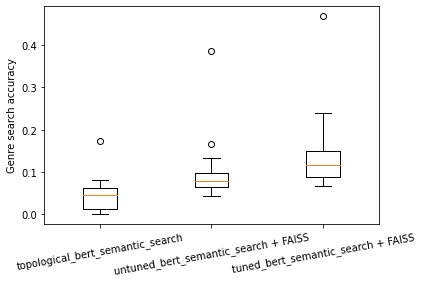

In [38]:
labels, data = [*zip(*genre_hit_rate.items())]  # 'transpose' items to parallel key, value lists
data = [list(data_dict.values()) for data_dict in data]
plt.boxplot(data)
plt.ylabel('Genre search accuracy')
plt.xticks(range(1, len(labels) + 1), labels, rotation=10)
plt.show()

In [39]:
from scipy import stats

for model, d in zip(labels, data):
  print(model, stats.describe(d), np.mean(d), np.median(d))

topological_bert_semantic_search DescribeResult(nobs=12, minmax=(0.001, 0.172), mean=0.048999999999999995, variance=0.0022570909090909095, skewness=1.4178193104540018, kurtosis=1.7605129088028963) 0.048999999999999995 0.046
untuned_bert_semantic_search + FAISS DescribeResult(nobs=12, minmax=(0.044, 0.385), mean=0.10833333333333334, variance=0.008761515151515152, skewness=2.3868348175358336, kurtosis=4.635635015561342) 0.10833333333333334 0.0775
tuned_bert_semantic_search + FAISS DescribeResult(nobs=12, minmax=(0.066, 0.468), mean=0.14950000000000002, variance=0.012714818181818183, skewness=2.055647508158211, kurtosis=3.4452790595040756) 0.14950000000000002 0.11549999999999999


topological_bert_semantic_search 0.048999999999999995
untuned_bert_semantic_search + FAISS 0.10833333333333334
tuned_bert_semantic_search + FAISS 0.14950000000000002


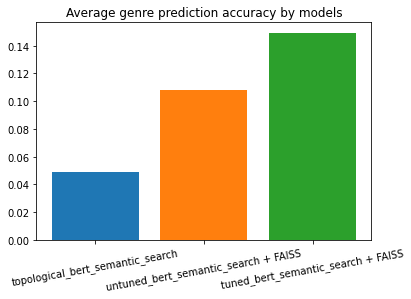

In [27]:
plt.figure()
for m, d in genre_hit_rate.items():
  plt.bar(height=np.mean(list(d.values())), x=m)
  print(m, np.mean(list(d.values())))
plt.xticks(rotation=10)
plt.title('Average genre prediction accuracy by models')
plt.show()

In [ ]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True) 

from rake_nltk import Rake
r = Rake()
rake_keywords = {}

for i, row in df.iterrows():
  r.extract_keywords_from_text(row['Plot'])
  rake_keywords[row['Plot']] = r.get_ranked_phrases_with_scores()

In [ ]:
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
def get_model_based_cos_similarity(text_a, text_b, similarity_model):
  from sentence_transformers import util
  #Compute cosine-similarities for each sentence with each other sentence
  return util.cos_sim(similarity_model.encode(text_a, convert_to_tensor=True), similarity_model.encode(text_b, convert_to_tensor=True)).item()

In [ ]:
def get_countvector_based_cos_similarity(s1, s2):
    # sentences to list
    allsentences = [s1 , s2]
    
    # packages
    from sklearn.feature_extraction.text import CountVectorizer
    from scipy.spatial import distance
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    # print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return round(1-cosine, 4)


In [ ]:
def plot_search_quality(models, plot_to_search_dict, show_n, similarity_method='model', n_samples=1000):
  plot_similarity = {}
  i = 0
  for orig_plot, key_words in plot_to_search_dict.items():
    if i > n_samples:
      break
    if i % 100 == 0:
      print(i)
    plot_query = " ".join([key_word[1] for idx, key_word in enumerate(key_words) if idx < 5])
    for model_name, model in models.items():
      if model_name not in plot_similarity:
        plot_similarity[model_name] = []
      results = model.search(plot_query, show_n=show_n)
      for res in results:
        if 'model' in similarity_method:
           similarity = get_model_based_cos_similarity(orig_plot, res['Plot'], similarity_model)
        elif 'count' in similarity_method:
          similarity = get_countvector_based_cos_similarity(orig_plot, res['Plot'])
        plot_similarity[model_name].append(similarity)
    i += 1
  return plot_similarity
# {model_name: {'mean': np.mean(scores), 'max':np.max(scores), 'min':np.min(scores), 'std':np.std(scores)} for model_name, scores in plot_similarity.items()}

In [ ]:
model_based_plot_similarity_keywords = plot_search_quality(models, rake_keywords, show_n=100, similarity_method='model')

In [ ]:
pickle_out = open(f"model_based_plot_similarity_keywords.pickle", "wb")
pickle.dump(model_based_plot_similarity_keywords, pickle_out)
pickle_out.close()

In [28]:
# pickle_in = open("model_based_plot_similarity_keywords.pickle", "rb")
# model_based_plot_similarity_keywords = pickle.load(pickle_in)
# pickle_in.close()

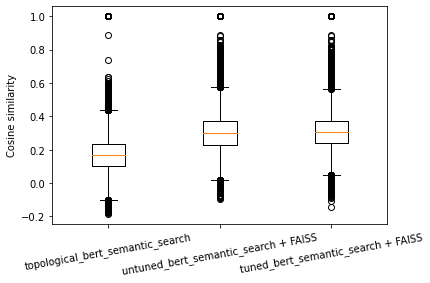

In [40]:
labels, data = [*zip(*model_based_plot_similarity_keywords.items())]  # 'transpose' items to parallel key, value lists
plt.boxplot(data)
plt.ylabel('Cosine similarity')
plt.xticks(range(1, len(labels) + 1), labels, rotation=10)
plt.show()

In [41]:
for model, d in zip(labels, data):
  print(model, stats.describe(d), np.mean(d), np.median(d))

topological_bert_semantic_search DescribeResult(nobs=100100, minmax=(-0.18389883637428284, 1.000000238418579), mean=0.172118670598073, variance=0.010363643504025325, skewness=0.7560753502329283, kurtosis=4.44282708594327) 0.172118670598073 0.16795359551906586
untuned_bert_semantic_search + FAISS DescribeResult(nobs=100100, minmax=(-0.09608175605535507, 1.000000238418579), mean=0.30516737300621627, variance=0.014679617300981636, skewness=1.5835650306746782, kurtosis=7.812127553747505) 0.30516737300621627 0.2981119006872177
tuned_bert_semantic_search + FAISS DescribeResult(nobs=100100, minmax=(-0.1431911736726761, 1.000000238418579), mean=0.31246796531332927, variance=0.013447488100862916, skewness=1.7830393466304144, kurtosis=9.511786932095642) 0.31246796531332927 0.30729520320892334


In [ ]:
count_based_plot_similarity = plot_search_quality(models, rake_keywords, show_n=100, similarity_method='count')

In [ ]:
pickle_out = open(f"count_based_plot_similarity.pickle", "wb")
pickle.dump(count_based_plot_similarity, pickle_out)
pickle_out.close()

In [33]:
# pickle_in = open("count_based_plot_similarity.pickle", "rb")
# count_based_plot_similarity = pickle.load(pickle_in)
# pickle_in.close()

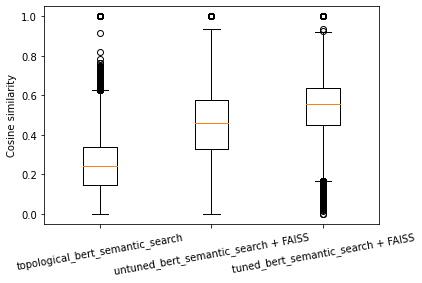

In [42]:
labels, data = [*zip(*count_based_plot_similarity.items())]  
plt.boxplot(data)
plt.ylabel('Cosine similarity')
plt.xticks(range(1, len(labels) + 1), labels, rotation=10)
plt.show();

In [43]:
for model, d in zip(labels, data):
  print(model, stats.describe(d), np.mean(d), np.median(d))

topological_bert_semantic_search DescribeResult(nobs=100100, minmax=(0.0, 1.0), mean=0.24787901298701298, variance=0.01881528020849842, skewness=0.4380357891236164, kurtosis=0.4798231294434947) 0.24787901298701298 0.2413
untuned_bert_semantic_search + FAISS DescribeResult(nobs=100100, minmax=(0.0, 1.0), mean=0.44949583716283714, variance=0.03056164056559352, skewness=-0.05511066870442141, kurtosis=-0.09268761383826218) 0.44949583716283714 0.4613
tuned_bert_semantic_search + FAISS DescribeResult(nobs=100100, minmax=(0.0, 1.0), mean=0.5368360419580421, variance=0.02200890595658122, skewness=-0.35390353592350476, kurtosis=0.47417039931641236) 0.5368360419580421 0.5549


In [ ]:
def paraphraser(text, num_return_sequences=3, num_beams=3, model_name="tuner007/pegasus_paraphrase"):
  from transformers import PegasusForConditionalGeneration, PegasusTokenizerFast
  model = PegasusForConditionalGeneration.from_pretrained(model_name)
  tokenizer = PegasusTokenizerFast.from_pretrained(model_name)
  tokens = tokenizer([text], truncation=True, padding="longest", return_tensors="pt")
  outputs = model.generate(tokens.input_ids, num_beams=num_beams, num_return_sequences=num_return_sequences)
  return tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [ ]:
paraphraser('Learning is the process of acquiring new understanding, knowledge, and behaviors.')

['Learning is the process of acquiring new knowledge.',
 'Learning is the process of gaining new knowledge.',
 'Learning is the acquisition of new knowledge.']

Get paraphrased plots to be used as queries.

In [ ]:
from random import sample
random_idx = sample(list(range(df.shape[0])), 1000)

paraphrased_plots = {}
k = 0
for i, row in df.iterrows():
  if i not in random_idx:
    continue
  if k % 100 == 0:
    print(k)
  k += 1
  paraphrased_plots[row['Plot']] = paraphraser(row['Plot'], num_return_sequences=1, num_beams=5)

In [ ]:
# pickle_out = open(f"paraphrased_plots.pickle", "wb")
# pickle.dump(paraphrased_plots, pickle_out)
# pickle_out.close()

In [ ]:
pickle_in = open("paraphrased_plots.pickle", "rb")
paraphrased_plots = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
len(paraphrased_plots)

1000

In [ ]:
model_based_plot_similarity_paraphrased_plots = plot_search_quality(models, paraphrased_plots, show_n=100, similarity_method='model')

In [ ]:
# pickle_out = open(f"model_based_plot_similarity_paraphrased_plots.pickle", "wb")
# pickle.dump(model_based_plot_similarity_paraphrased_plots, pickle_out)
# pickle_out.close()

In [36]:
# pickle_in = open("model_based_plot_similarity_paraphrased_plots.pickle", "rb")
# model_based_plot_similarity_paraphrased_plots = pickle.load(pickle_in)
# pickle_in.close()

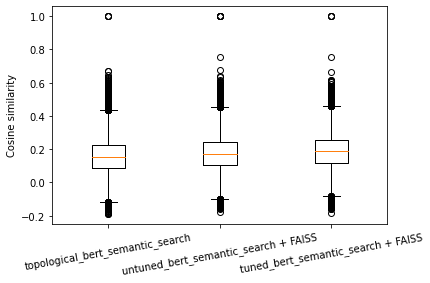

In [44]:
labels, data = [*zip(*model_based_plot_similarity_paraphrased_plots.items())]  
plt.boxplot(data)
plt.ylabel('Cosine similarity')
plt.xticks(range(1, len(labels) + 1), labels, rotation=10)
plt.show()

In [46]:
for model, d in zip(labels, data):
  print(model, stats.describe(d), np.mean(d), np.median(d))

topological_bert_semantic_search DescribeResult(nobs=100000, minmax=(-0.18929317593574524, 1.0000001192092896), mean=0.16060589828961297, variance=0.010705188944630746, skewness=0.30570019221300937, kurtosis=0.24653426423238622) 0.16060589828961297 0.155197411775589
untuned_bert_semantic_search + FAISS DescribeResult(nobs=100000, minmax=(-0.17567408084869385, 1.0000001192092896), mean=0.17639754170141184, variance=0.010278989566942072, skewness=0.21020151647532745, kurtosis=0.20267938684169629) 0.17639754170141184 0.17329883575439453
tuned_bert_semantic_search + FAISS DescribeResult(nobs=100000, minmax=(-0.1848665475845337, 1.0), mean=0.1878942391341133, variance=0.010056420850920119, skewness=0.15282381859324254, kurtosis=0.12378649139447662) 0.1878942391341133 0.18565576523542404


In [ ]:
paraphrased_plots[list(paraphrased_plots.keys())[0]]

['A pair of boys play a trick on a detective who thinks he is a better sleuth than a famous detective.']

In [ ]:
list(paraphrased_plots.keys())[0]

"Hemlock Hoax is a detective who has little respect in the small tropical town where he lives, despite the fact that he thinks he is a better sleuth than Sherlock Holmes. A pair of boys decide to play a trick on Hoax and tell him about a murder. Hoax rushes to scene of the crime where he discovers a shred of cloth, later finding that a tramp is wearing the same type of clothes that he found. The tramp runs away and Hoax gives chase, with other people helping the pursuit. Eventually, Hoax captures the tramp with the aid of a police officer, and returns to the victim's body with the man. Hoax then comes to a realization that the body was just a dummy that had been stuffed with the leaves. The crowd has a laugh at Hoax's expense while the two boys are punished.[1]"

In [ ]:
df.Plot[0]

"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"